In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

# OUR LIBRARIES / FUNCTIONS
from ImageLoader import load_image, plot_loaded_images
from StarDetector import get_hough_circles, plot_detected_stars, get_stars_data

# GLOBAL VARIABLES
# im1_path = r'Boaz stars 1.png'
# im2_path = r'Boaz stars 2.png'
im1_path = r'Stars/IMG_3046.HEIC'
im2_path = r'Stars/IMG_3047.HEIC'

In [2]:
im1 = load_image(im1_path)
im2 = load_image(im2_path)

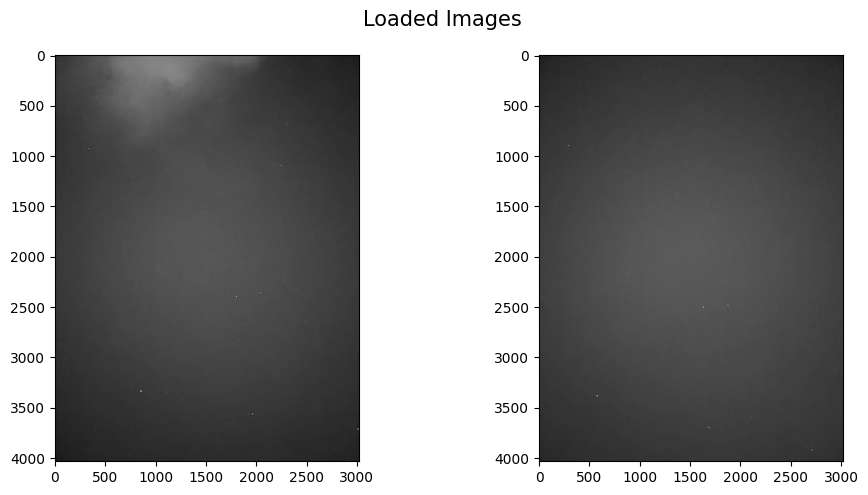

In [3]:
plot_loaded_images(im1, im2)
plt.show()

In [4]:
im1_circles = get_hough_circles(im1)
im2_circles = get_hough_circles(im2)

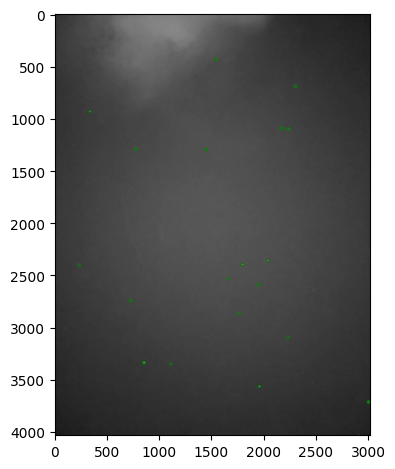

In [5]:
plot_detected_stars(im1, im1_circles)

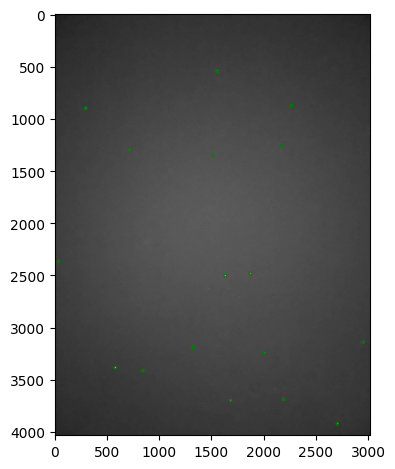

In [6]:
plot_detected_stars(im2, im2_circles)

In [7]:
im1_data = get_stars_data(im1, as_pandas=True)
im2_data = get_stars_data(im2, as_pandas=True)

In [8]:
im1_data

,x,y,r,b
0,189.0,129.0,5.0,65.0
1,166.0,234.0,3.0,72.0
2,247.0,53.0,3.0,60.0
3,6.0,94.0,3.0,54.0
4,84.0,9.0,5.0,55.0
5,79.0,162.0,3.0,65.0
6,255.0,177.0,4.0,72.0
7,188.0,22.0,3.0,57.0
8,7.0,173.0,4.0,63.0
9,190.0,73.0,4.0,61.0


In [9]:
im2_data

,x,y,r,b
0,65.0,55.0,5.0,35.0
1,81.0,178.0,4.0,42.0
2,147.0,82.0,5.0,42.0
3,94.0,199.0,4.0,41.0
4,146.0,112.0,3.0,41.0
5,136.0,68.0,3.0,42.0
6,40.0,129.0,5.0,40.0
7,209.0,168.0,4.0,43.0
8,201.0,18.0,3.0,34.0
9,34.0,64.0,4.0,39.0
